SpaceX launch anlysis
Analyzing SpaceX launch data from the public API to understand launch success rates by rocket, pad and year

#1 Fetch launch data
Start by calling the '/launches' endpoint of the SpaceX API and store the data in a dataframe.

In [25]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# API endpoint for all launches
url = "https://api.spacexdata.com/v4/launches"

# Fetch data
response = requests.get(url)
if response.status_code == 200:
    launches = response.json()
   
else:
    print("Error fetching data:", response.status_code)
    launches = []

# Extract relevant fields
launch_data = []
for launch in launches:
    launch_data.append({
        "launch_name": launch["name"],
        "date": launch["date_utc"],
        "success": launch["success"],
        "rocket_id": launch["rocket"],
        "payloads": len(launch["payloads"]),
        "launchpad_id": str(launch["launchpad"])
    })

# Convert to DataFrame
df = pd.DataFrame(launch_data)

df.to_csv('data/spacex_launches.csv', index=False)

#2 Add Rocket Names
Fetch rocket data from '/rockets' endpoint and join on rocket_id. adding actual rocket name to dataframe

In [27]:
all_rockets_url = f"https://api.spacexdata.com/v4/rockets"

all_rocket_res = requests.get(all_rockets_url)

all_rockets = all_rocket_res.json()

rocket_df = pd.DataFrame([{
    "rocket_id": rocket["id"]
    ,"rocket_name": rocket["name"]
} for rocket in all_rockets])

df = df.merge(rocket_df, on="rocket_id", how="left")

#3 Fetch launchpad data
Join on launchpad id, adding a launchpad name and location to the data.

In [28]:
launchpads_url = "https://api.spacexdata.com/v4/launchpads"

launchpads_res = requests.get(launchpads_url)

launchpads = launchpads_res.json()

launchpad_df = pd.DataFrame([{
    "launchpad_id": pad["id"]
    ,"launchpad_name": pad["name"]
    ,"launchpad_location": pad["locality"]
} for pad in launchpads ])

df = df.merge(launchpad_df, on="launchpad_id", how="left")

#4 Launch Success Summary
Convert launch dates to datetime format and extract the launch year. Then, we group the data by rocket name, launchpad, and year to calculate:
- **Total launches**
- **Number of successful launches**
- **Success rate (%)**
The result is a summary table showing launch performance across different rockets, pads, and years.

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

grouped_df = df.groupby(["rocket_name","launchpad_name","year"])

summary = grouped_df["success"].agg(
    total_launches="count"
    ,successful_launches = lambda x: x.sum()
    ,success_rate=lambda x:(x.sum() / x.count()) * 100
).reset_index()

summary = summary.sort_values(by="success_rate", ascending=False)
print(summary)

#5 Export Summary Data
Export summerized launch performance data to a CSV file under 'data' folder

In [30]:
summary.to_csv('data/spacex_summary.csv', index=False)

#6 Launches per Rocket
Plot a bar chart showing the number of launches per rocket. Giving a quick view of which rockets are most active.

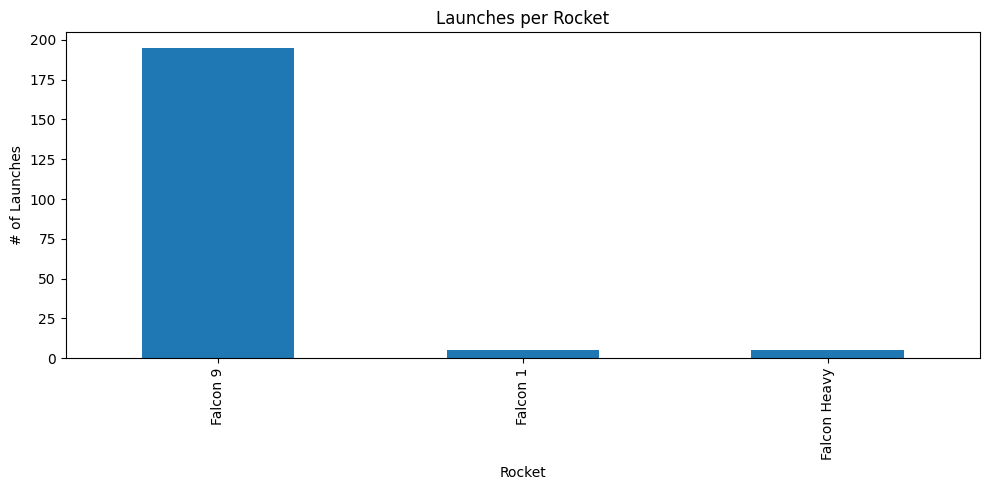

In [31]:

rocket_counts = df['rocket_name'].value_counts()
rocket_counts.plot(kind='bar', figsize=(10,5), title='Launches per Rocket')
plt.xlabel('Rocket')
plt.ylabel('# of Launches')
plt.tight_layout()
plt.show()

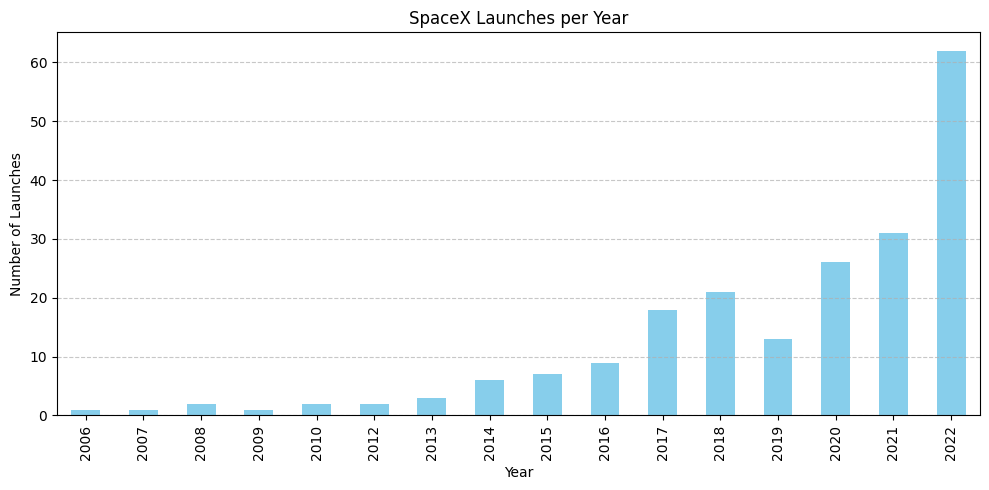

In [32]:
# Group by year and count launches
launches_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
launches_per_year.plot(kind='bar', color='skyblue')
plt.title('SpaceX Launches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

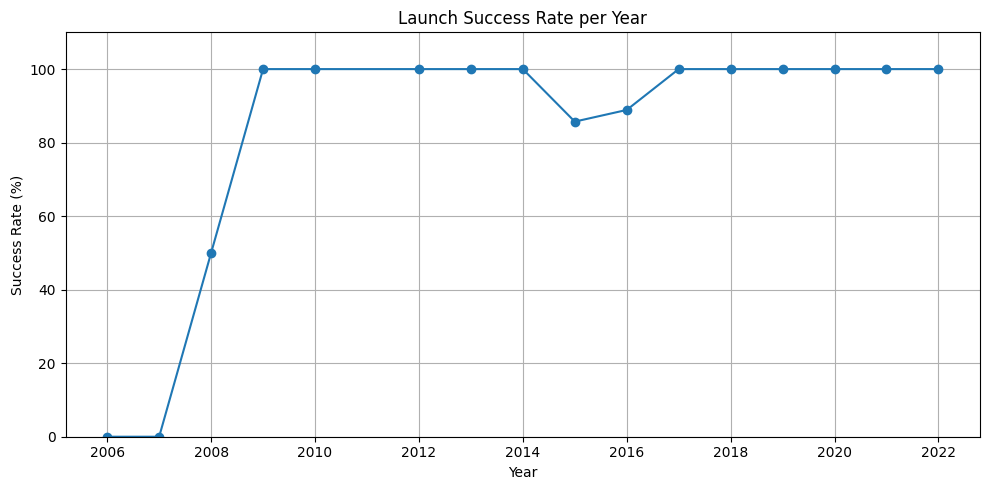

In [33]:
# Calculate success rate per year
success_by_year = df.groupby('year')['success'].agg(
    total='count',
    successful='sum'
)
success_by_year['success_rate'] = (success_by_year['successful'] / success_by_year['total']) * 100

# Plot
plt.figure(figsize=(10,5))
success_by_year['success_rate'].plot(marker='o', linestyle='-')
plt.title('Launch Success Rate per Year')
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 110)
plt.grid(True)
plt.tight_layout()
plt.show()